## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [54]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [55]:
# Place 
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes
channel_id_list = ['UCBi2mrWuNuyYy4gbM6fU18Q'] #ABCNews
channel_id_list = ['UCeY0bbntWzzVIaj2z3QigXg'] #NBCNews
channel_id_list = ['UCaXkIU1QidjPwiAYu6GcHjg'] #MSNBC

In [56]:
# Create Youtube Data API object & cleaned dataframe containing video data from selected channel using function from youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object
video_df = create_video_df(youtube_obj, channel_id_list, 500) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [57]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [58]:
video_ids = list(selected_df['video_id'])

In [59]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [60]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,Mo0uGTXOI48,UgzM7eLqk-LaKzXyQ7d4AaABAg,"Repent, Jesus wants you!",2022-09-22T22:01:23Z
1,Mo0uGTXOI48,UgzaVNC2O2bCMRNTIpB4AaABAg,"More to the point, how many copies of these do...",2022-09-22T22:01:17Z
2,Mo0uGTXOI48,UgyPoljoPk5YC-Wu7tx4AaABAg,"by the title of this video, intel often holds ...",2022-09-22T22:01:16Z
3,Mo0uGTXOI48,UgwyOo3gs8sWNrcX3Y14AaABAg,9 traitors you mean,2022-09-22T22:00:54Z
4,Mo0uGTXOI48,UgxlFa_EFaOoTv8NsQd4AaABAg,MSNBC is the worst FAKE NEWS on TV. How can th...,2022-09-22T22:00:10Z


In [61]:
all_comments_df['comment'][3]

'9 traitors you mean'

## Comment Data Cleaning

In [62]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [63]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

In [64]:
all_comments_df

,video_id,comment_id,comment,date
0,Mo0uGTXOI48,UgzM7eLqk-LaKzXyQ7d4AaABAg,"Repent, Jesus wants you!",2022-09-22T22:01:23Z
1,Mo0uGTXOI48,UgzaVNC2O2bCMRNTIpB4AaABAg,"More to the point, how many copies of these do...",2022-09-22T22:01:17Z
2,Mo0uGTXOI48,UgyPoljoPk5YC-Wu7tx4AaABAg,"by the title of this video, intel often holds ...",2022-09-22T22:01:16Z
3,Mo0uGTXOI48,UgwyOo3gs8sWNrcX3Y14AaABAg,9 traitors you mean,2022-09-22T22:00:54Z
4,Mo0uGTXOI48,UgxlFa_EFaOoTv8NsQd4AaABAg,MSNBC is the worst FAKE NEWS on TV. How can th...,2022-09-22T22:00:10Z
...,...,...,...,...
28518,an2CezI6P8k,UgzFcQ9HnmpvyfJJ1CV4AaABAg,Let's go Bannon!,2022-09-09T13:37:13Z
28519,an2CezI6P8k,UgwJUBzzcbOMsNb6DRl4AaABAg,Its pretty obvious where the donors money went...,2022-09-09T13:32:17Z
28520,an2CezI6P8k,UgxTqRQrMpNwPt6sgDB4AaABAg,"The caption actually said ""Frog Marched"" 🤣😂🤣🤣🤣🤟🏽",2022-09-09T13:23:55Z
28521,an2CezI6P8k,UgzckbAH5FCAhrkfu4p4AaABAg,Banon will screw you over and protect your rig...,2022-09-09T13:20:19Z


In [65]:
all_comments_df['comment'][3]

'9 traitors you mean'

## VADER NLP

In [66]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [67]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [68]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,Mo0uGTXOI48,Classified Docs Often Contain 'Life Or Death' ...,-0.107191,45116,1502.0
1,ShrxBrNLVLU,'This Reversal Will Be A Permanent Part Of Jud...,-0.068474,363206,10450.0
2,_mlLkxSLa68,'Documents Don't Lie; Square Footage Doesn't L...,-0.020497,178632,5574.0
3,w7km9Znrohw,Trump Charges?: Anticipated Jan. 6 Report Hits...,0.000955,35792,1040.0
4,aX8ABP4A7gE,Sen. Durbin: It Troubles Me Greatly Some Of My...,-0.138860,206664,5304.0
...,...,...,...,...,...
283,Xvq-sBVmOyQ,NBC News Confirms Biden Will Attend Queen Eliz...,0.010662,147063,1302.0
284,yx8HNCJTztM,Reproductive Rights Has Galvanized Michigan Vo...,-0.086847,137332,3986.0
285,eeiog3IHZ34,Is There A Chance Steve Bannon Could Serve Tim...,-0.054576,132689,2039.0
286,R9hcVZZ9glE,Watch The Last Word With Lawrence O’Donnell Hi...,-0.024125,278617,5674.0


## Data Visualization

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

Find the interactive graph [here](https://cjunwon.github.io/Youtube-Data-Analysis/).

In [70]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark'
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='vscode')

pio.write_html(fig, file='index.html', auto_open=True)

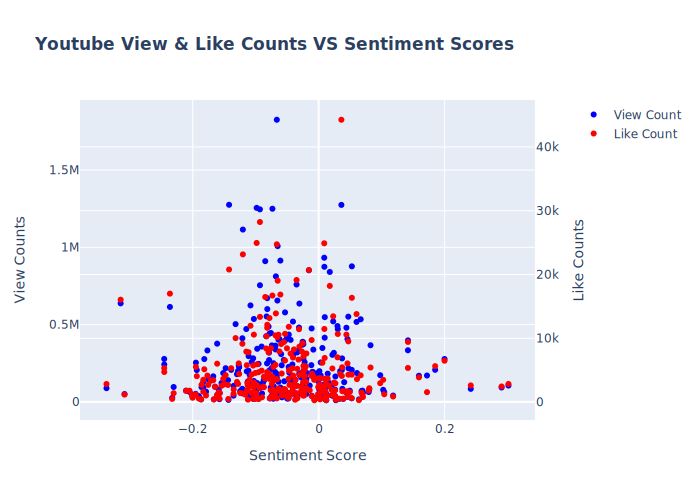

In [71]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score"
    # legend_title="Legend Title"
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='svg')

In [72]:
test_df = video_comp_sentiments

In [73]:
test_df

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,Mo0uGTXOI48,Classified Docs Often Contain 'Life Or Death' ...,-0.107191,45116,1502.0
1,ShrxBrNLVLU,'This Reversal Will Be A Permanent Part Of Jud...,-0.068474,363206,10450.0
2,_mlLkxSLa68,'Documents Don't Lie; Square Footage Doesn't L...,-0.020497,178632,5574.0
3,w7km9Znrohw,Trump Charges?: Anticipated Jan. 6 Report Hits...,0.000955,35792,1040.0
4,aX8ABP4A7gE,Sen. Durbin: It Troubles Me Greatly Some Of My...,-0.138860,206664,5304.0
...,...,...,...,...,...
283,Xvq-sBVmOyQ,NBC News Confirms Biden Will Attend Queen Eliz...,0.010662,147063,1302.0
284,yx8HNCJTztM,Reproductive Rights Has Galvanized Michigan Vo...,-0.086847,137332,3986.0
285,eeiog3IHZ34,Is There A Chance Steve Bannon Could Serve Tim...,-0.054576,132689,2039.0
286,R9hcVZZ9glE,Watch The Last Word With Lawrence O’Donnell Hi...,-0.024125,278617,5674.0


In [74]:
test_df['avg_comp_sentiment'] = np.where(test_df['avg_comp_sentiment'] > 0, test_df['avg_comp_sentiment'] * 2, test_df['avg_comp_sentiment'])
test_df['avg_comp_sentiment'] = np.where(test_df['avg_comp_sentiment'] < 0, test_df['avg_comp_sentiment'] * -1, test_df['avg_comp_sentiment'])

In [75]:
test_df

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,Mo0uGTXOI48,Classified Docs Often Contain 'Life Or Death' ...,0.107191,45116,1502.0
1,ShrxBrNLVLU,'This Reversal Will Be A Permanent Part Of Jud...,0.068474,363206,10450.0
2,_mlLkxSLa68,'Documents Don't Lie; Square Footage Doesn't L...,0.020497,178632,5574.0
3,w7km9Znrohw,Trump Charges?: Anticipated Jan. 6 Report Hits...,0.001909,35792,1040.0
4,aX8ABP4A7gE,Sen. Durbin: It Troubles Me Greatly Some Of My...,0.138860,206664,5304.0
...,...,...,...,...,...
283,Xvq-sBVmOyQ,NBC News Confirms Biden Will Attend Queen Eliz...,0.021324,147063,1302.0
284,yx8HNCJTztM,Reproductive Rights Has Galvanized Michigan Vo...,0.086847,137332,3986.0
285,eeiog3IHZ34,Is There A Chance Steve Bannon Could Serve Tim...,0.054576,132689,2039.0
286,R9hcVZZ9glE,Watch The Last Word With Lawrence O’Donnell Hi...,0.024125,278617,5674.0


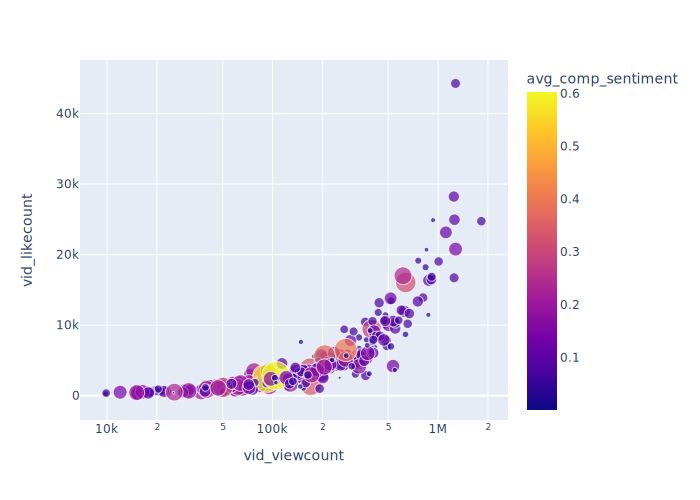

In [78]:
import plotly.express as px

fig = px.scatter(test_df, x="vid_viewcount", y="vid_likecount",
	         size="avg_comp_sentiment",
             color="avg_comp_sentiment", hover_name="vid_title", log_x=True)
fig.show(renderer='svg')

In [77]:
selected_df

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,favoriteCount,commentCount,caption,publishDayName,durationSecs,tagCount
4,Mo0uGTXOI48,MSNBC,Classified Docs Often Contain 'Life Or Death' ...,Representative Jason Crow (D-CO) joins Andrea ...,2022-09-22,45116,1502,0,1289,1,Thursday,360.0,1
7,ShrxBrNLVLU,MSNBC,'This Reversal Will Be A Permanent Part Of Jud...,A federal appeals court said Wednesday that th...,2022-09-22,363206,10450,0,1964,1,Thursday,354.0,3
8,_mlLkxSLa68,MSNBC,'Documents Don't Lie; Square Footage Doesn't L...,Ari Melber and defense attorney Caroline Polis...,2022-09-22,178632,5574,0,1592,1,Thursday,522.0,3
9,w7km9Znrohw,MSNBC,Trump Charges?: Anticipated Jan. 6 Report Hits...,The January 6th committee will conclude its wo...,2022-09-22,35792,1040,0,547,1,Thursday,143.0,1
13,aX8ABP4A7gE,MSNBC,Sen. Durbin: It Troubles Me Greatly Some Of My...,"Judiciary Committee Chair, Sen. Dick Durbin, D...",2022-09-22,206664,5304,0,1622,1,Thursday,541.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,Xvq-sBVmOyQ,MSNBC,NBC News Confirms Biden Will Attend Queen Eliz...,NBC News has confirmed that President Biden wi...,2022-09-09,147063,1302,0,1686,1,Friday,122.0,28
488,yx8HNCJTztM,MSNBC,Reproductive Rights Has Galvanized Michigan Vo...,Michigan voters this fall will decide whether ...,2022-09-09,137332,3986,0,1876,1,Friday,555.0,27
489,eeiog3IHZ34,MSNBC,Is There A Chance Steve Bannon Could Serve Tim...,Former Trump adviser Steve Bannon was charged ...,2022-09-09,132689,2039,0,1125,1,Friday,146.0,23
492,R9hcVZZ9glE,MSNBC,Watch The Last Word With Lawrence O’Donnell Hi...,Watch highlights from The Last Word with Lawre...,2022-09-09,278617,5674,0,1052,0,Friday,1253.0,3


In [83]:
fig = go.Figure()
fig.add_trace(go.Bar(x=selected_df['publishDayName'],
                y=selected_df['viewCount'],
                name='Rest of world',
                marker_color='rgb(55, 83, 109)'
                ))

fig.update_layout(
    title='US Export of Plastic Scrap',
    xaxis_tickfont_size=14,
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [ ]:
fig = go.Figure([go.Bar(x=animals, y=[20, 14, 23])])
fig.show()